In [82]:
%matplotlib inline

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle

In [84]:
import librosa as lb

In [85]:
ANNOTATIONS_ROOT = Path('Chopin_Mazurkas/annotations_beat')
query_list = Path('cfg_files/query.test.list')

# For modified files
query_list_train_toy = Path('cfg_files/filelist.train_toy.txt')
query_list_train_small = Path('cfg_files/filelist.train_small.txt')
query_list_train_medium = Path('cfg_files/filelist.train_medium.txt')
query_list_train_full = Path('cfg_files/filelist.train_full.txt')
query_list_test_full = Path('cfg_files/filelist.test_full.txt')

### Evaluate hypothesis directory

First evaluate a single hypothesis directory.

In [86]:
def eval_dir(hypdir, querylist, hop_sec, annotation_root1, annotation_root2, savefile = None):
    allErrs = {}
    cnt = 0
    print(f'Processing {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            allErrs[basename] = eval_file(hypfile, hop_sec, annotation_root1, annotation_root2)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        pickle.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs

In [87]:
def eval_file(hypfile, hop_sec, annotation_root1, annotation_root2):
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    annotfile1 = (Path(annotation_root1) / piece / parts[0]).with_suffix('.beat')
    annotfile2 = (Path(annotation_root2) / piece / parts[1]).with_suffix('.beat')
    gt1 = getTimestamps(annotfile1)
    gt2 = getTimestamps(annotfile2)
    hypalign = loadAlignment(hypfile) # warping path in frames
    if hypalign is None:
        err = [] # no valid path
    else:
        pred2 = np.interp(gt1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec)
        err = pred2 - gt2
    return err

In [88]:
def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

In [89]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [90]:
def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pickle.load(f)
    return d

Evaluate a single hypothesis directory.

In [15]:
# hypdir = 'experiments_test/test_full...DTW1'
# savefile = 'evaluations_test/test_full...DTW1.pkl'
# hop_sec = 512 * 1 / 22050
# allErrs = eval_dir(hypdir, query_list_test_full, hop_sec, ANNOTATIONS_ROOT, ANNOTATIONS_ROOT, savefile)

Processing experiments_test/test_full...DTW1 ....... done


Evaluate all hypothesis directories.

In [91]:
def eval_all_dirs(rootdir, querylist, hop_sec, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    reldir = str(querylist).split('.')[1]
    for hypdir in glob.glob(f'{rootdir}/{reldir}*'): # NOT SURE IF THIS WORKS
        savefile = outdir + '/' + os.path.basename(hypdir) + '.pkl'
        # get annotation_root1, annotation_root2
        info = hypdir.split('.')
        annotation_root1 = 'Mazurkas_median_{}.{}/annotations_beat'.format(info[1][:2], info[1][2:])
        annotation_root2 = 'Mazurkas_median_{}.{}/annotations_beat'.format(info[2][:2], info[2][2:])
        allErrs = eval_dir(hypdir, querylist, hop_sec, annotation_root1, annotation_root2, savefile = savefile)

In [92]:
EXPERIMENTS_ROOT = 'experiments_test'
hop_sec = 512 * 1 / 22050
outdir = 'evaluations_test'
eval_all_dirs(EXPERIMENTS_ROOT, query_list_train_toy, hop_sec, outdir) # evaluate all directories with train_toy

Processing experiments_test/train_toy.x1588.x0630.DTW1  done
Processing experiments_test/train_toy.x1260.x0794.DTW_adaptiveWeight1  done
Processing experiments_test/train_toy.x1588.x0794.DTW1_downsampleQuantized  done
Processing experiments_test/train_toy.x1588.x0794.DTW2  done
Processing experiments_test/train_toy.x2000.x0500.DTW1_downsampleInterpolate  done
Processing experiments_test/train_toy.x1588.x0794.DTW1_upsampleQuantized  done
Processing experiments_test/train_toy.x1260.x1000.DTW3  done
Processing experiments_test/train_toy.x1000.x1000.DTW_adaptiveWeight1  done
Processing experiments_test/train_toy.x2000.x0500.DTW1_upsampleInterpolate  done
Processing experiments_test/train_toy.x2000.x0500.DTW1  done
Processing experiments_test/train_toy.x1588.x0630.DTW2  done
Processing experiments_test/train_toy.x1260.x0794.DTW2  done
Processing experiments_test/train_toy.x1000.x1000.DTW1_upsampleInterpolate  done
Processing experiments_test/train_toy.x1260.x1000.DTW1_upsampleQuantized  don

### Plot error vs tolerance

##### Helper functions for plotting graphs

In [93]:
def get_global_time_warp(num1, num2):
    ''' calculate global time warp from two numbers'''
    return round(num1/num2, 3)

In [94]:
def get_info_from_basename(dir):
    '''get system, global_time_warp from basename (name of a folder)'''
    info = dir.split('.')
    system = info[3]
    num1 = float('{}.{}'.format(info[1][1], info[1][2:]))
    num2 = float('{}.{}'.format(info[2][1], info[2][2:]))
    global_time_warp = get_global_time_warp(num1, num2)
    return system, global_time_warp

In [95]:
def get_folder_names(filelist, alignments_list):
    '''create a list of lists of folder names corresponding to filelist and alignment types'''
    all_folders = []
    for alignment in alignments_list:
        to_concat = ['{}.x1000.x1000.{}'.format(filelist, alignment), '{}.x1260.x0794.{}'.format(filelist, alignment), '{}.x1260.x1000.{}'.format(filelist, alignment),
                     '{}.x1588.x0630.{}'.format(filelist, alignment), '{}.x1588.x0794.{}'.format(filelist, alignment),
                     '{}.x2000.x0630.{}'.format(filelist, alignment), '{}.x2000.x0500.{}'.format(filelist, alignment)]
        
        all_folders = all_folders + to_concat
    return all_folders


##### Calculate errors

In [96]:
def calc_error_rates(errFile, maxTol):
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [97]:
def calc_error_rates_batch(indir, basenames, maxTol):
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir + '/' + basename + '.pkl'
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print(' done')
    return errRates, allErrVals

In [98]:
def plot_multiple_roc(errRates, basenames):
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
        
    # create appropriate legend names corresponding to basenames
    legend = []
    for folder in basenames:
        system, global_time_warp = get_info_from_basename(folder)
        legend.append('Global Time Warp = {}, {}'.format(global_time_warp, system))
    
    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

Change the 'toPlot' list to include only the alignment algorithms we've run so far.

In [105]:
EVAL_ROOT_DIR = 'evaluations_test'
toPlot = get_folder_names('train_toy', ['DTW1', 'DTW2', 'DTW3', 'DTW1_add3', 'DTW1_add4', 'DTW1_downsampleQuantized','DTW1_downsampleInterpolate','DTW1_upsampleQuantized','DTW1_upsampleInterpolate', 'DTW_adaptiveWeight1', 'DTW_adaptiveWeight2'])
maxTol = 1000 # in msec
errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)

Computing error rates ............................................................................. done


In [ ]:
plot_multiple_roc(errRates, toPlot)

### Grouped barplot: 7 groups corresponding to 7 different global time warp factors

In [113]:
def generate_df(errRates, basenames, tols):
    '''generates df to use with histogram'''
    data = []
    for i, dir in enumerate(basenames):
        # get system from basename
        system, global_time_warp = get_info_from_basename(dir)
        # for tol in tols:
        for tol in tols:
            # get errors and append
            data.append((system, tol, errRates[i,tol]*100, global_time_warp))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error', 'Global Time Warp'])

    # check for NaN which indicates a false path and set error to 100
    #df.fillna(100, inplace=True)

    return df

In [1]:
def plot_grouped_histogram1(df):  
    plt.figure(figsize=(10,10))
    # Histogram grouped by tolerance
    tol_200 = df[df['Tolerance']==200]
    tol_500 = df[df['Tolerance']==500]
    tol_100 = df[df['Tolerance']==100]
    # graph100 = sns.barplot(data=tol_100, x="Global Time Warp", y="Error", hue="System", edgecolor="black", linewidth=1)
    graph200 = sns.barplot(data=tol_500, x="Global Time Warp", y="Error", hue="System", palette="rocket")
    # graph500 = sns.barplot(data=tol_500, x="Global Time Warp", y="Error", hue="System", edgecolor="black", linewidth=1)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Global Time Warp", size=16)
    plt.ylabel("Error Rate", size=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
    plt.grid()
    plt.show()
    
    return

In [3]:
df1 = generate_df(errRates, toPlot, [200, 500, 100])

NameError: name 'generate_df' is not defined

In [2]:
plot_grouped_histogram1(df1)

NameError: name 'df1' is not defined

## Histogram from paper

In [31]:
def plot_grouped_histogram1(errRates_bars, errRates_dots, basenames, tols, savefile = None):  
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot (DTW & WSDTW)
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate (%)", size=14)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc='upper right')
    
    # overlay dots for SSDTW results
    width_bar = .135
    x_coords = []
    y_coords = []
    for i, tol in enumerate(tols):
        for j in range(errRates_dots.shape[0]):
            x_coords.append(i+(-1.5+j)*width_bar)
            y_coords.append(errRates_dots[j,tol] * 100.0)
    plt.plot(x_coords, y_coords, 'ko', markersize=3)
    
    if savefile:
        plt.savefig(savefile, bbox_inches = 'tight')
    return df

,System,Tolerance,Error
0,DTW,10,74.655177
1,DTW,20,55.672810
2,DTW,50,29.834394
3,DTW,100,17.209739
4,DTW,200,8.536578
5,DTW,500,3.399190


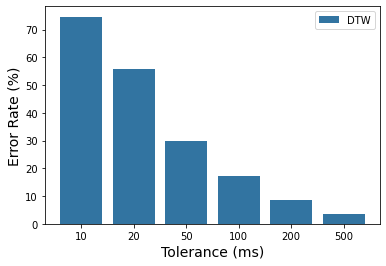

In [32]:
tols = [10, 20, 50, 100, 200, 500] # in msec
display_names = ['DTW']#, 'SegDTW-2', 'SegDTW-4', 'SegDTW-8', 'SegDTW-16','SegDTW-32']
savefile = 'results.png'
plot_grouped_histogram1(errRates[0:6,:], errRates[6:,:], display_names, tols, savefile)